# Setup

In [ ]:
# Standard library imports
import json
import math
import os
import random
from collections import defaultdict

# Third-party imports
import matplotlib.pyplot as plt
import numpy as np

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

This collection of lines imports various modules and libraries necessary for a machine learning project, specifically one utilizing PyTorch.

The first section brings in modules from Python’s standard library. `json` is used for working with JSON data formats. `math` provides mathematical functions. `os` allows interaction with the operating system (like file path manipulation). `random` generates pseudo-random numbers. `defaultdict` from the `collections` module creates dictionaries that automatically assign a default value to keys if they don’t already exist.

Next, several third-party libraries are imported. `matplotlib.pyplot` is for creating visualizations like plots and charts. `numpy` provides support for numerical operations, especially with arrays. 

Finally, the code imports components from the PyTorch deep learning framework. `torch` is the core library. `torch.nn` contains classes for building neural networks. `torch.nn.functional` offers functional implementations of various neural network layers and activation functions. `torch.optim` provides optimization algorithms (like gradient descent) to train models.  `torch.utils.data` includes tools for managing datasets, specifically `DataLoader` for creating batches of data and `TensorDataset` for wrapping tensors into a dataset object. 

These imports establish the foundation for tasks such as loading data, defining neural network architectures, training those networks, and visualizing results.

In [2]:
# general settings
class CFG:
    img_dim1 = 20
    img_dim2 = 10
    SEED = 42
    SES_ALPHA = 0.3
    device = 'cpu'


# display style 
plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (CFG.img_dim1, CFG.img_dim2)

# fix randomness - insofar as possible ;-) 
torch.manual_seed(CFG.SEED)
np.random.seed(CFG.SEED)
random.seed(CFG.SEED)

# Setup
device = torch.device(CFG.device)
print(f"Using device: {device}")
print(f"PyTorch Version: {torch.__version__}")


# Global parameters for our experiment
NUM_SERIES_TRAIN = 100
NUM_SERIES_TEST = 20
NUM_STEPS = 300
CONTEXT_LENGTH = 50 # How many past steps the L1 models see
FORECAST_HORIZON = 24 # How many future steps to predict
NUM_FOLDS = 5 # K for time series cross-validation

Using device: cpu
PyTorch Version: 2.10.0


This section of code establishes configuration settings and performs initial setup for a time series experiment.

First, a class named `CFG` is defined to hold global parameters. It sets the dimensions of images used for visualization (`img_dim1`, `img_dim2`), a random seed for reproducibility (`SEED`), an alpha value likely related to smoothing or weighting (`SES_ALPHA`), and specifies whether to use the central processing unit ('cpu') for computations (`device`).

Next, the code adjusts the plotting style using Matplotlib. It selects the "seaborn-v0_8" style and sets the default figure size based on the image dimensions defined in the `CFG` class. 

Following this, the random number generators for PyTorch, NumPy, and the standard Python `random` module are seeded with the value specified in `CFG.SEED`. This aims to ensure consistent results across multiple runs of the experiment.

The code then sets up the computational device by creating a PyTorch device object based on the `CFG.device` setting. It prints which device is being used and displays the version of PyTorch installed. 

Finally, several global parameters are defined for the time series analysis itself. These include the number of training (`NUM_SERIES_TRAIN`) and testing (`NUM_SERIES_TEST`) time series, the total number of steps in each series (`NUM_STEPS`), the length of the historical data used as input to a model (`CONTEXT_LENGTH`), the number of future steps that the model is expected to predict (`FORECAST_HORIZON`), and the number of folds for cross-validation (`NUM_FOLDS`).

# Utils

In [3]:
def generate_time_series(num_series: int, num_steps: int) -> np.ndarray:

    series_data = []
    for _ in range(num_series):
        slope = np.random.uniform(-0.1, 0.1)
        amplitude = np.random.uniform(0.5, 5.0)
        # Use a mix of seasonalities
        period = random.choice([12, 24, 36])
        noise_level = np.random.uniform(0.1, 1.0)

        time = np.arange(num_steps)
        seasonality = amplitude * np.sin(2 * np.pi * time / period)
        trend = slope * time
        noise = noise_level * np.random.randn(num_steps)

        # Add a random starting point
        start_point = np.random.uniform(-10, 10)

        series_data.append(start_point + trend + seasonality + noise)

    return np.array(series_data, dtype=np.float32)

This function constructs a set of synthetic time series datasets. It takes the number of time series to generate (`num_series`) and the length of each time series (`num_steps`) as input. 

The code initializes an empty list called `series_data` which will hold each generated time series. A loop then iterates `num_series` times, creating one time series in each iteration. Within the loop, random parameters are assigned to define the characteristics of each series: a `slope` for linear trend, an `amplitude` controlling the strength of seasonal patterns, a `period` determining the length of those seasons (chosen randomly from 12, 24 or 36), and a `noise_level` representing the amount of random fluctuation.

A time array is created using `np.arange(num_steps)`, representing the points in time for each series. The core components of each time series – `seasonality`, `trend`, and `noise` – are then calculated based on these parameters.  The seasonality is modeled as a sine wave, the trend as a linear increase or decrease, and the noise as random values drawn from a normal distribution. A random `start_point` is added to each series to shift its overall level.

Finally, all components (start point, trend, seasonality, and noise) are summed together to create the complete time series, which is appended to the `series_data` list. After generating all the specified time series, the function returns them as a NumPy array with a data type of 32-bit floating-point numbers.

In [4]:
def create_sliding_windows(data: np.ndarray, context_length: int, forecast_horizon: int) -> tuple[np.ndarray, np.ndarray]:
    X, Y = [], []
    num_series, num_steps = data.shape
    for i in range(num_series):
        for j in range(num_steps - context_length - forecast_horizon + 1):
            X.append(data[i, j:j+context_length])
            Y.append(data[i, j+context_length:j+context_length+forecast_horizon])
    return np.array(X), np.array(Y)

This function prepares time series data for supervised learning by creating sliding windows. It takes the time series `data` (a NumPy array), a `context_length` defining the size of the input window, and a `forecast_horizon` specifying how many steps ahead to predict as inputs.

The function initializes two empty lists, `X` and `Y`, which will store the input features and target values respectively. It determines the number of time series (`num_series`) and the length of each time series (`num_steps`) from the shape of the input data. 

Nested loops then iterate through each time series and each possible starting point within that series. The outer loop iterates over the `num_series`, while the inner loop slides a window across each individual time series.  The range of the inner loop is calculated to ensure there are enough data points remaining to create both an input sequence (`context_length`) and a corresponding target sequence (`forecast_horizon`).

Inside the loops, a slice of the data representing the `context_length` past values is extracted as the input feature (X) and appended to the `X` list.  Another slice, representing the subsequent `forecast_horizon` values, is extracted as the target value (Y) and added to the `Y` list.

Finally, after processing all time series and sliding windows, the function converts both `X` and `Y` lists into NumPy arrays and returns them as a tuple. These arrays are now formatted for use in training a machine learning model to predict future values based on past observations.

In [5]:
def train_pytorch_model(model: nn.Module,
                        data: np.ndarray,
                        context_length: int,
                        forecast_horizon: int,
                        is_stacker: bool = False,
                        epochs: int = 20,
                        lr: float = 0.001,
                        verbose: bool = True):

    model.to(CFG.device)
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.L1Loss() # MAE Loss

    if not is_stacker:
        # L1 model training: data is raw time series
        X_train, y_train = create_sliding_windows(data, context_length, forecast_horizon)
    else:
        # L2 stacker training: data is a tuple of (L1_preds, ground_truth)
        X_train, y_train = data

    if len(X_train) == 0:
        if verbose: print("  Warning: No training data available for this fold. Skipping training.")
        return

    dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
    loader = DataLoader(dataset, batch_size=32, shuffle=True)

    for epoch in range(epochs):
        total_loss = 0
        for x_batch, y_batch in loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        if verbose and (epoch + 1) % 10 == 0:
            print(f'  Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(loader):.4f}')


This function implements a standard training loop for a PyTorch neural network model designed for time series forecasting. It takes the `model` to be trained, the input `data`, parameters defining the sliding window (`context_length`, `forecast_horizon`), flags indicating whether it's part of a stacked model (`is_stacker`), and hyperparameters like the number of training `epochs` and learning rate (`lr`) as inputs. A `verbose` flag controls output during training.

First, the function moves the model to the specified device (defined by `CFG.device` - set in the config at the beginning of the notebook) and sets it to training mode using `model.train()`. It then initializes an Adam optimizer with the given learning rate to update the model's parameters and selects L1Loss (Mean Absolute Error) as the loss function, measuring the difference between predicted and actual values.

The code handles two scenarios based on the `is_stacker` flag. If it’s not a stacker model (i.e., a base level model), it calls the `create_sliding_windows` function to transform the raw time series data into input-output pairs suitable for supervised learning.  If it *is* a stacker model, it assumes that the input `data` is already in the correct format – a tuple containing predictions from a lower-level model and the corresponding ground truth values.

A check ensures there's training data available; if not, a warning message is printed, and the function returns without further action. 

The code then creates a PyTorch `TensorDataset` from the input features (`X_train`) and target values (`y_train`), converting them to tensors. A `DataLoader` is used to create batches of data for efficient training with a batch size of 32 and shuffling enabled.

The core training loop iterates through each epoch. Inside, it accumulates the total loss across all batches. For each batch, the input and target tensors are moved to the specified device. The optimizer's gradients are zeroed out (`optimizer.zero_grad()`), a forward pass is performed to get the model’s output, the loss is calculated using the chosen criterion, backpropagation computes the gradients, and finally, the optimizer updates the model parameters.

If `verbose` is true and the epoch number is a multiple of 10, the function prints the current epoch number and the average loss for that epoch. This provides feedback on the training progress.

In [6]:
def predict_pytorch_model(model: nn.Module, x_data: np.ndarray) -> np.ndarray:
    model.eval()
    with torch.no_grad():
        x_tensor = torch.from_numpy(x_data).to(device)
        preds = model(x_tensor)
    return preds.cpu().numpy()

This function performs predictions using a trained PyTorch model. It takes the `model` and input data `x_data` as arguments, returning the predicted values as a NumPy array.

First, it sets the model to evaluation mode using `model.eval()`. This is important because certain layers (like dropout or batch normalization) behave differently during training and evaluation. 

The code then uses a `with torch.no_grad():` block. This context manager disables gradient calculation, which reduces memory consumption and speeds up inference since gradients are not needed for prediction.

Inside the block, the input data `x_data` is converted into a PyTorch tensor and moved to the specified device (defined by the global variable `device`). The model then processes this tensor using `model(x_tensor)` to generate predictions (`preds`). 

Finally, the predicted values are transferred back to the CPU using `.cpu()` and converted from a PyTorch tensor to a NumPy array using `.numpy()`. This NumPy array containing the predictions is returned by the function.

In [7]:
def generate_l1_oof_predictions(l1_models: dict, data: np.ndarray, num_folds: int, context_length: int, forecast_horizon: int) -> tuple[np.ndarray, np.ndarray]:
    """
    Implements time series cross-validation to get out-of-fold predictions from L1 models.
    This corresponds to Step 1 in Figure 1.B and Figure 2.B.
    """
    print("--- Generating L1 Out-of-Fold (OOF) Predictions ---")

    num_series, num_steps = data.shape
    # The total length available for training/validation windows
    max_train_len = num_steps - forecast_horizon

    all_oof_preds = defaultdict(list)
    all_oof_targets = []

    for k in range(num_folds):
        # Step 1a: Define a temporal split point.
        # This is the 'L1-Train' part in the paper's diagrams.
        # j = (K - k) in the paper's notation (if k starts from 0)
        end_idx = max_train_len - (num_folds - 1 - k) * forecast_horizon
        train_fold_data = data[:, :end_idx]

        # The validation window is the next H steps.
        # This is 'L1-Pred' target in the paper's diagrams.
        val_context = data[:, end_idx - context_length : end_idx]
        val_target = data[:, end_idx : end_idx + forecast_horizon]

        print(f"Fold {k+1}/{num_folds}: Training L1 models on data up to step {end_idx}")

        if val_target.shape[0] == 0: continue

        all_oof_targets.append(val_target)

        # Step 1b & 1c: Train each base model and predict.
        for name, model in l1_models.items():
            if isinstance(model, nn.Module):
                # Create a fresh instance to avoid continued training
                if isinstance(model, LinearModel):
                    current_model = LinearModel(context_length, forecast_horizon)
                else:
                    current_model = MLPModel(context_length, forecast_horizon)
                train_pytorch_model(current_model, train_fold_data, context_length, forecast_horizon, verbose=False)
                preds = predict_pytorch_model(current_model, val_context)
            else: # For scikit-learn style models
                model.fit(None, None) # fit is a no-op for Naive
                preds = model.predict(val_context)
            all_oof_preds[name].append(preds)

    # Step 3: Collect all out-of-fold predictions.
    # L1-Pred from the paper is the input for the L2 stacker.
    oof_targets = np.concatenate(all_oof_targets, axis=0)

    # Stack predictions from all models: shape (num_samples, num_models, horizon)
    oof_preds_stacked = np.stack([np.concatenate(all_oof_preds[name], axis=0) for name in l1_models.keys()], axis=1)

    print(f"Finished L1 OOF generation.")
    print(f"Shape of L1 OOF predictions (L1-Pred features): {oof_preds_stacked.shape}")
    print(f"Shape of L1 OOF targets (L1-Pred targets): {oof_targets.shape}")

    return oof_preds_stacked, oof_targets

This function implements a time series cross-validation procedure to generate out-of-fold (OOF) predictions from a set of level 1 (L1) models. It’s designed to mimic the process described in Figures 1.B and 2.B of a related paper, focusing on creating data for a subsequent level 2 (L2) stacking model.

The function begins by printing a message indicating it's generating L1 OOF predictions. It retrieves the shape of the input `data` (number of time series and number of steps).  It calculates `max_train_len`, representing the maximum length of data available for training in any fold, considering the need to reserve space for the forecast horizon.

A `defaultdict(list)` called `all_oof_preds` is initialized to store predictions from each L1 model across all folds. A list `all_oof_targets` will hold the corresponding ground truth values (validation targets). 

The code then iterates through `num_folds`, performing cross-validation. Inside the loop, it defines a temporal split point (`end_idx`) that determines where to divide the data into training and validation sets for each fold. This ensures that the validation set always represents future time steps relative to the training set, maintaining the chronological order of the time series. The `train_fold_data` is extracted up to this index.

The validation context (`val_context`) and target (`val_target`) are then defined using slices from the original data.  The `val_context` represents the input window for prediction, while `val_target` holds the actual values that will be predicted. A check ensures there is actually validation data available; if not, it skips to the next fold.

A message is printed indicating which portion of the data is being used for training in the current fold. The ground truth targets (`val_target`) are appended to `all_oof_targets`. 

Next, the code iterates through each L1 model stored in the `l1_models` dictionary. For PyTorch models (instances of `nn.Module`), a fresh instance of the model is created for each fold to avoid continued training from previous folds. The appropriate model class (`LinearModel` or `MLPModel`) is instantiated based on the type of the original model.  The `train_pytorch_model` function is called to train this new instance using the current fold’s training data. Predictions are then generated for the validation context using `predict_pytorch_model`. For non-PyTorch models (~ scikit-learn style), a no-op fit is performed, and predictions are made directly with the model's predict method. The predictions from each model are appended to the corresponding list in `all_oof_preds`.

After all folds have been processed, the code concatenates the validation targets (`all_oof_targets`) into a single NumPy array called `oof_targets`. It then stacks the predictions from all L1 models across all folds using `np.stack`, creating an array with shape (number of samples, number of models, forecast horizon). This stacked array represents the features for the level 2 stacker model.

Finally, the function prints messages indicating completion and displaying the shapes of the OOF predictions and targets. It returns both `oof_preds_stacked` and `oof_targets`.

In [8]:
def train_multi_layer_stacker(l1_models, l2_stackers, l3_aggregator, data, num_folds, context_length, forecast_horizon):

    # Step 1: Train L1 models with K-fold CV to get L1-Pred
    l1_oof_preds, l1_oof_targets = generate_l1_oof_predictions(l1_models, data, num_folds, context_length, forecast_horizon)

    # Step 2: Split L1-Pred for L2/L3 training
    # The paper uses the last window for the L3 model. The size of one window is num_series.
    num_series = data.shape[0]
    l2_train_preds = l1_oof_preds[:-num_series, :, :]
    l2_train_targets = l1_oof_targets[:-num_series, :]
    l3_train_preds_input = l1_oof_preds[-num_series:, :, :]
    l3_train_targets = l1_oof_targets[-num_series:, :]

    print("\n--- Training L2 Stackers and Generating L3 Training Data ---")
    l2_oof_preds = []
    for name, stacker in l2_stackers.items():
        print(f"Training L2 Stacker: {name}")
        # Step 3a: Train L2 stacker on the first K-1 folds of L1-Pred
        if isinstance(stacker, nn.Module):
            train_pytorch_model(stacker, (l2_train_preds, l2_train_targets), context_length, forecast_horizon, is_stacker=True, epochs=50)
            # Step 3b: Generate L2 OOF predictions on the K'th fold
            preds = predict_pytorch_model(stacker, l3_train_preds_input)
        else:
            stacker.fit(l2_train_preds, l2_train_targets)
            preds = stacker.predict(l3_train_preds_input)
        l2_oof_preds.append(preds)

    # This is L2-Pred: input for the L3 model
    l2_oof_preds_stacked = np.stack(l2_oof_preds, axis=1)
    print(f"Shape of L2 OOF predictions (L3 training features): {l2_oof_preds_stacked.shape}")
    print(f"Shape of L3 training targets: {l3_train_targets.shape}")

    # Step 4: Train L3 model
    print("\n--- Training L3 Aggregator ---")
    l3_aggregator.fit(l2_oof_preds_stacked, l3_train_targets)

    # Step 5 & 6: Retrain L1 and L2 models on all available data for inference
    print("\n--- Retraining Models on Full Data ---")
    print("Retraining L1 models...")
    for name, model in l1_models.items():
        if isinstance(model, nn.Module):
            train_pytorch_model(model, data, context_length, forecast_horizon, verbose=False, epochs=50)

    print("Retraining L2 stackers...")
    for name, stacker in l2_stackers.items():
        if isinstance(stacker, nn.Module):
            train_pytorch_model(stacker, (l1_oof_preds, l1_oof_targets), context_length, forecast_horizon, is_stacker=True, epochs=50, verbose=False)

    print("\n--- Training Complete ---")
    return l1_models, l2_stackers, l3_aggregator

This part implements the main training orchestrator for the full multi-layer stack ensemble - follows the procedure from Figure 2.B in the paper. It orchestrates the training of level 1 (L1) models, level 2 (L2) stackers, and a level 3 (L3) aggregator to create a robust prediction system.

The process begins by calling `generate_l1_oof_predictions` to train the L1 models using K-fold cross-validation and obtain out-of-fold predictions (`l1_oof_preds`) and corresponding targets (`l1_oof_targets`). These OOF predictions serve as input for training the L2 stackers.

Next, the code splits the L1 OOF data into training sets for the L2 models and a separate set to generate training data for the L3 aggregator. The last K folds of the L1 OOF predictions are reserved for training the L3 model, mirroring the approach described in the referenced paper. `l2_train_preds` and `l2_train_targets` contain the data used to train the L2 stackers, while `l3_train_preds_input` and `l3_train_targets` are used for training the L3 aggregator.

The function then iterates through each L2 stacker in the `l2_stackers` dictionary. For each stacker, it trains the model using the `train_pytorch_model` function (or a standard fit method for non-PyTorch models) on the `l2_train_preds` and `l2_train_targets`. It then generates predictions on the data reserved for L3 training (`l3_train_preds_input`) using either `predict_pytorch_model` or the stacker’s predict method. These predictions are stored in the `l2_oof_preds` list.

The predictions from all L2 stackers are stacked together using `np.stack`, creating a multi-dimensional array (`l2_oof_preds_stacked`) that serves as input for the L3 aggregator. The shapes of these features and the corresponding L3 training targets are printed for verification.

Finally, the L3 aggregator is trained on the stacked L2 predictions (`l2_oof_preds_stacked`) and the `l3_train_targets` using its fit method. 

The function concludes by retraining all L1 models and L2 stackers on the full dataset to prepare them for making final predictions. This ensures that the models are optimized based on all available data, not just the cross-validation folds. The retrained models (L1 models, L2 stackers, and L3 aggregator) are then returned by the function.



In [9]:
def multilayer_inference(input_history: np.ndarray, l1_models: dict, l2_stackers: dict, l3_aggregator) -> np.ndarray:

    print("--- Performing Multi-layer Inference ---")

    # Step 1: L1 Prediction
    l1_preds = []
    for name, model in l1_models.items():
        if isinstance(model, nn.Module):
            pred = predict_pytorch_model(model, input_history)
        else:
            pred = model.predict(input_history)
        l1_preds.append(pred)
    l1_preds_stacked = np.stack(l1_preds, axis=1)
    print(f"L1 predictions shape: {l1_preds_stacked.shape}")

    # Step 2: L2 Prediction
    l2_preds = []
    for name, stacker in l2_stackers.items():
        if isinstance(stacker, nn.Module):
            pred = predict_pytorch_model(stacker, l1_preds_stacked)
        else:
            pred = stacker.predict(l1_preds_stacked)
        l2_preds.append(pred)
    l2_preds_stacked = np.stack(l2_preds, axis=1)
    print(f"L2 predictions shape: {l2_preds_stacked.shape}")

    # Step 3: L3 Aggregation
    final_forecast = l3_aggregator.predict(l2_preds_stacked)
    print(f"Final forecast shape: {final_forecast.shape}")

    return final_forecast

This function performs inference (prediction) using a pre-trained three-layer stacking ensemble. It takes the input history (`input_history`), the trained L1 models (`l1_models`), the trained L2 stackers (`l2_stackers`), and the trained L3 aggregator as inputs, returning the final forecast.

The function begins by printing a message indicating it's performing multi-layer inference. 

First, it generates predictions from each of the L1 models. It iterates through the `l1_models` dictionary, using either `predict_pytorch_model` for PyTorch models or the model’s predict method for other types (like scikit-learn models). The individual predictions are collected in a list called `l1_preds`, which is then stacked into a NumPy array (`l1_preds_stacked`) along axis 1. This creates an array where each row represents the predictions from one L1 model. The shape of this array is printed for verification.

Next, it generates predictions from each of the L2 stackers using the `l1_preds_stacked` as input. Similar to the L1 prediction step, it iterates through the `l2_stackers`, applies the appropriate prediction method (PyTorch or standard predict), and stacks the results into a NumPy array (`l2_preds_stacked`). The shape of this array is also printed.

Finally, the function uses the trained L3 aggregator to combine the predictions from the L2 stackers (`l2_preds_stacked`) into a final forecast. It calls the aggregator’s predict method and stores the result in `final_forecast`.  The shape of the final forecast is printed before being returned by the function.

In essence, this function simulates the forward pass through the entire stacked ensemble, starting with the individual L1 models, combining their outputs using the L2 stackers, and then aggregating those results using the L3 aggregator to produce a single, comprehensive prediction.

In [10]:
def evaluate_performance():
    print("\n--- Running Final Evaluation on Test Set ---")

    # Prepare test data
    X_test, y_test = create_sliding_windows(test_data, CONTEXT_LENGTH, FORECAST_HORIZON)

    # --- Method 1: Best L1 Model (Model Selection) ---
    # Find best L1 model based on OOF performance
    l1_oof_preds, l1_oof_targets = generate_l1_oof_predictions(l1_models_to_train, train_data, NUM_FOLDS, CONTEXT_LENGTH, FORECAST_HORIZON)
    l1_model_names = list(l1_models_to_train.keys())
    l1_oof_errors = []
    for i in range(len(l1_model_names)):
        error = np.mean(np.abs(l1_oof_preds[:, i, :] - l1_oof_targets))
        l1_oof_errors.append(error)
        print(f"L1 Model '{l1_model_names[i]}' OOF MAE: {error:.4f}")

    best_l1_idx = np.argmin(l1_oof_errors)
    best_l1_name = l1_model_names[best_l1_idx]
    best_l1_model = l1_models_final[best_l1_name]
    print(f"==> Best L1 Model selected: {best_l1_name}")

    if isinstance(best_l1_model, nn.Module):
        best_l1_preds = predict_pytorch_model(best_l1_model, X_test)
    else:
        best_l1_preds = best_l1_model.predict(X_test)
    mae_best_l1 = np.mean(np.abs(best_l1_preds - y_test))

    # --- Generate L1 predictions on test set for other methods ---
    l1_test_preds = []
    for name, model in l1_models_final.items():
        if isinstance(model, nn.Module):
            pred = predict_pytorch_model(model, X_test)
        else:
            pred = model.predict(X_test)
        l1_test_preds.append(pred)
    l1_test_preds_stacked = np.stack(l1_test_preds, axis=1)

    # --- Method 2: Median Baseline ---
    median_stacker = MedianStacker()
    median_preds = median_stacker.predict(l1_test_preds_stacked)
    mae_median = np.mean(np.abs(median_preds - y_test))

    # --- Method 3: Single-Layer Stacker (Linear) ---
    single_layer_linear_stacker = l2_stackers_final['LinearStacker']
    single_layer_preds = predict_pytorch_model(single_layer_linear_stacker, l1_test_preds_stacked)
    mae_single_layer = np.mean(np.abs(single_layer_preds - y_test))

    # --- Method 4: Multi-Layer Stacker ---
    multi_layer_preds = multilayer_inference(X_test, l1_models_final, l2_stackers_final, l3_aggregator_final)
    mae_multi_layer = np.mean(np.abs(multi_layer_preds - y_test))

    # --- Print Results Table ---
    print("\n--- Final Performance Results (MAE on Test Set) ---")
    print("=====================================================")
    print(f"| Method                    | MAE     | Improvement vs Median |")
    print("|---------------------------|---------|-----------------------|")
    print(f"| Best L1 ({best_l1_name})       | {mae_best_l1:.4f} | {100*(mae_median-mae_best_l1)/mae_median:6.2f}%               |")
    print(f"| Median Baseline           | {mae_median:.4f} | 0.00%                 |")
    print(f"| Single-Layer (Linear)     | {mae_single_layer:.4f} | {100*(mae_median-mae_single_layer)/mae_median:6.2f}%               |")
    print(f"| Multi-Layer Stacker       | {mae_multi_layer:.4f} | {100*(mae_median-mae_multi_layer)/mae_median:6.2f}%               |")
    print("=====================================================")

    return {
        "Best L1": best_l1_preds,
        "Median": median_preds,
        "Multi-Layer": multi_layer_preds,
        "Ground Truth": y_test
    }

This function performs a final evaluation of the trained models on a held-out test set. It compares the performance of several methods: the best single L1 model, a median baseline, a single-layer stacker, and the full multi-layer stacking ensemble.

The function begins by printing a message indicating it's running the final evaluation. It prepares the test data by creating sliding windows using `create_sliding_windows`.

It then proceeds to identify the best L1 model based on its out-of-fold (OOF) performance. It generates OOF predictions and calculates the Mean Absolute Error (MAE) for each L1 model, printing these errors for comparison. The model with the lowest OOF MAE is selected as the best L1 model. Predictions are then generated using this best model on the test data (`X_test`).

Next, it generates predictions from all L1 models on the test set and stacks them into a NumPy array (`l1_test_preds_stacked`), which will be used as input for the stackers. 

The function evaluates three stacking methods: a median baseline (simply taking the median of the L1 model predictions), a single-layer linear stacker, and the full multi-layer stacker. Predictions are generated using each method, and their MAEs are calculated by comparing them to the ground truth test targets (`y_test`).

Finally, it prints a formatted table summarizing the performance results for each method, including the MAE and the percentage improvement over the median baseline. The function returns a dictionary containing the predictions from the best L1 model, the median baseline, the multi-layer stacker, and the ground truth test targets. This allows for further analysis or visualization of the results.

In [11]:
def plot_forecast_comparison(predictions: dict, series_idx: int):
    plt.figure(figsize=(CFG.img_dim1 , CFG.img_dim2))
    plt.title(f"Forecast Comparison on Test Series #{series_idx}")

    # Get a continuous segment for plotting
    context = test_data[series_idx, -CONTEXT_LENGTH-FORECAST_HORIZON:-FORECAST_HORIZON]
    full_truth = test_data[series_idx, -CONTEXT_LENGTH-FORECAST_HORIZON:]

    time_hist = np.arange(CONTEXT_LENGTH)
    time_future = np.arange(CONTEXT_LENGTH, CONTEXT_LENGTH + FORECAST_HORIZON)

    # Find the corresponding prediction in the batched results
    # For this visualization, let's just use the first window of the test set
    pred_idx = 0
    while pred_idx * (NUM_STEPS - CONTEXT_LENGTH - FORECAST_HORIZON + 1) < series_idx:
        pred_idx +=1

    plt.plot(time_hist, context, 'k-', label='History')
    plt.plot(time_future, predictions["Ground Truth"][pred_idx], 'g-', label='Ground Truth', linewidth=2)
    plt.plot(time_future, predictions["Median"][pred_idx], 'b--', label='Median Baseline')
    plt.plot(time_future, predictions["Multi-Layer"][pred_idx], 'r-', label='Multi-Layer Stack')

    plt.axvline(x=CONTEXT_LENGTH, color='gray', linestyle='--', label='Forecast Start')
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()

This function visualizes the forecast performance of different models on a single time series from the test set. It takes a dictionary of predictions (`predictions`) and the index of the time series to plot (`series_idx`) as input.

The function begins by creating a figure and setting its size, then adds a title indicating which test series is being plotted. 

It extracts a segment of historical data (`context`) from the `test_data` representing the recent past used for forecasting, along with the corresponding ground truth values (`full_truth`). It also defines time arrays for the history and future forecast horizons.

The code then calculates the correct index (`pred_idx`) into the batched predictions to retrieve the forecasts for the specified series. This is necessary because the predictions were generated in batches during inference. 

It plots the historical context in black, the ground truth values in green with a thicker line width, the median baseline prediction in blue dashed lines, and the multi-layer stacker’s prediction in red solid lines. A vertical gray dashed line marks the point where the forecast begins (the end of the history). 

Finally, it adds labels to the x and y axes, displays a legend, enables gridlines, and shows the plot using `plt.show()`. This allows for a visual comparison of the different forecasting methods against the actual values for a specific time series.

# Models

## L1 Base Models 

In [12]:
class SeasonalNaiveModel:
    def __init__(self, seasonality: int = 24):
        self.seasonality = seasonality

    def fit(self, x: np.ndarray, y: np.ndarray):
        # This model is non-parametric => nothing to fit 
        pass

    def predict(self, x: np.ndarray) -> np.ndarray:
        # x has shape (batch_size, context_length)
        # We need to predict for forecast_horizon steps
        context = x[:, -self.seasonality:]
        return np.tile(context, (1, math.ceil(FORECAST_HORIZON / self.seasonality)))[:, :FORECAST_HORIZON]

This class implements a Seasonal Naive forecasting model. This model predicts future values by repeating the most recent seasonal pattern observed in the historical data.

The `__init__` method initializes the model with a `seasonality` parameter, which defaults to 24. This parameter determines the length of the seasonal cycle that the model assumes exists in the time series.

The `fit` method is intentionally left empty because the Seasonal Naive model is non-parametric – it doesn’t learn any parameters from the training data. It simply repeats past observations, so no fitting process is required.

The `predict` method takes a batch of input sequences (`x`) as input. The shape of `x` is assumed to be (batch_size, context_length).  It extracts the last `self.seasonality` values from each sequence in the batch – this represents the most recent seasonal pattern. It then repeats this seasonal pattern enough times to cover the entire forecast horizon (`FORECAST_HORIZON`). The `np.tile` function is used for efficient repetition, and slicing ensures that only the required number of future steps are returned.  The result is a prediction array with shape (batch_size, FORECAST_HORIZON), where each row contains the forecasted values for a single time series in the batch.

In [13]:
class LinearModel(nn.Module):
    def __init__(self, context_length: int, forecast_horizon: int):
        super().__init__()
        self.linear = nn.Linear(context_length, forecast_horizon)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear(x)

This class defines a simple linear regression model implemented using PyTorch’s neural network module (`nn.Module`). It's designed for time series forecasting where the forecast is directly predicted from a fixed-length context window of past values.

The `__init__` method initializes the model. It calls the constructor of the parent class (`nn.Module`) and then defines a single linear layer (`self.linear`). This linear layer takes an input of size `context_length` (the number of past time steps used as input) and transforms it into an output of size `forecast_horizon` (the number of future time steps to predict).

The `forward` method implements the forward pass of the model. It takes a PyTorch tensor `x` representing the input data (a batch of context windows) and passes it through the linear layer (`self.linear`). The output of the linear layer, which represents the predicted values for the forecast horizon, is then returned as a PyTorch tensor.

In essence, this model learns a weight matrix that maps the input context window directly to the forecasted future values using a simple linear transformation.

In [14]:
class MLPModel(nn.Module):
    def __init__(self, context_length: int, forecast_horizon: int):
        super().__init__()
        self.fc1 = nn.Linear(context_length, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, forecast_horizon)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

This class defines a multi-layer perceptron (MLP) model implemented using PyTorch’s neural network module (`nn.Module`). It's designed for time series forecasting, providing a more complex non-linear mapping from the input context window to the forecasted future values compared to the `LinearModel`.

The `__init__` method initializes the model. It calls the constructor of the parent class (`nn.Module`) and then defines three fully connected (linear) layers: `self.fc1`, `self.fc2`, and `self.fc3`.  `self.fc1` maps the input context length to 128 hidden units, `self.fc2` further processes these 128 units, and finally, `self.fc3` maps the 128 hidden units to the desired forecast horizon.

The `forward` method implements the forward pass of the model. It takes a PyTorch tensor `x` representing the input data (a batch of context windows). The input is first passed through `self.fc1`, and then the ReLU activation function (`F.relu`) is applied to introduce non-linearity.  The result is then passed through `self.fc2`, followed by another ReLU activation. Finally, the output of `self.fc2` is passed through `self.fc3` to produce the final forecast, which is returned as a PyTorch tensor.

In summary, this model uses two hidden layers with ReLU activations to learn a more complex non-linear relationship between the input context window and the forecasted future values.

## L2 Stacker Models 

In [15]:
class MedianStacker:
    def fit(self, x: np.ndarray, y: np.ndarray):
        pass # Non-parametric

    def predict(self, x: np.ndarray) -> np.ndarray:
        # x has shape (num_samples, num_l1_models, forecast_horizon)
        return np.median(x, axis=1)

This class implements a simple median stacking ensemble model. It combines predictions from multiple level 1 (L1) models by taking the median of their forecasts.

The `fit` method is intentionally left empty because the MedianStacker is non-parametric – it doesn’t learn any parameters from the training data. It simply calculates the median, so no fitting process is required.

The `predict` method takes a NumPy array `x` as input, representing the predictions from the L1 models. The shape of `x` is assumed to be (num_samples, num_l1_models, forecast_horizon), where each row represents the forecasts from different L1 models for a single time series, and each element along the last axis represents the prediction for a specific future time step.

The function calculates the median across the L1 model predictions (`axis=1`) for each sample (time series). This results in an array with shape (num_samples, forecast_horizon), where each row contains the median forecast for a single time series. The resulting median forecasts are returned as a NumPy array.

In [16]:
class LinearStacker(nn.Module):
    """Learns a weighted average of L1 predictions."""
    def __init__(self, num_models: int, forecast_horizon: int):
        super().__init__()
        # We learn one weight per model, applied across the whole horizon
        self.weights = nn.Parameter(torch.ones(num_models) / num_models)
        self.forecast_horizon = forecast_horizon

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x has shape (batch_size, num_l1_models, forecast_horizon)
        # We want to compute a weighted sum over the num_l1_models dimension
        # Reshape weights to (1, num_l1_models, 1) for broadcasting
        w = self.weights.view(1, -1, 1)
        # Apply softmax to ensure weights sum to 1, as in the paper's simplex constraint
        w = F.softmax(w, dim=1)
        return (x * w).sum(dim=1)

This class defines a single-layer linear stacker model implemented using PyTorch’s neural network module (`nn.Module`). It learns a weighted average of the predictions from multiple level 1 (L1) models to create a more accurate combined forecast.

The `__init__` method initializes the model. It calls the constructor of the parent class (`nn.Module`) and then defines a learnable parameter called `self.weights`. This parameter is a PyTorch tensor that stores the weights assigned to each L1 model. The initial values are set to be equal, representing an unweighted average.  The `forecast_horizon` is stored for potential future use (though not currently utilized in this implementation).

The `forward` method implements the forward pass of the model. It takes a PyTorch tensor `x` as input, which represents the predictions from the L1 models. The shape of `x` is assumed to be (batch_size, num_l1_models, forecast_horizon), where each row corresponds to a sample (time series), and each column represents the prediction from one L1 model for all future time steps.

The code reshapes the `self.weights` tensor using `.view(1, -1, 1)` to enable broadcasting during multiplication with the input tensor `x`. This ensures that the weights are applied correctly across the forecast horizon. A softmax function (`F.softmax`) is then applied along dimension 1 (the L1 model dimension) to normalize the weights, ensuring they sum up to 1 and effectively imposing a simplex constraint as described in related research. Finally, it computes the weighted sum of the L1 predictions by multiplying `x` with the normalized weights `w` and summing over the L1 model dimension (`dim=1`). The resulting tensor represents the stacked prediction, which is returned by the function.

In [17]:
class MLPStacker(nn.Module):
    def __init__(self, num_models: int, forecast_horizon: int):
        super().__init__()
        self.num_models = num_models
        self.forecast_horizon = forecast_horizon
        # The input feature is all L1 models' predictions for a single time step
        self.fc1 = nn.Linear(num_models, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x has shape (batch_size, num_l1_models, forecast_horizon)
        # We need to process each horizon step independently
        # Reshape to (batch_size * forecast_horizon, num_l1_models)
        batch_size = x.shape[0]
        x_reshaped = x.permute(0, 2, 1).reshape(-1, self.num_models)

        h = F.relu(self.fc1(x_reshaped))
        h = F.relu(self.fc2(h))
        output = self.fc3(h)

        # Reshape back to (batch_size, forecast_horizon)
        return output.view(batch_size, self.forecast_horizon)

This class defines a multi-layer perceptron (MLP) stacker model implemented using PyTorch’s neural network module (`nn.Module`). It learns a non-linear combination of the predictions from multiple level 1 (L1) models to create a more accurate combined forecast.

The `__init__` method initializes the model. It calls the constructor of the parent class (`nn.Module`) and stores the number of L1 models (`num_models`) and the forecast horizon for potential future use.  It defines three fully connected (linear) layers: `self.fc1`, `self.fc2`, and `self.fc3`. The input to the MLP is the concatenation of predictions from all L1 models at a given time step, so `self.fc1` maps this input (size `num_models`) to 64 hidden units, `self.fc2` further processes these units, and finally, `self.fc3` maps the 64 hidden units to a single output value representing the stacked prediction for that time step.

The `forward` method implements the forward pass of the model. It takes a PyTorch tensor `x` as input, which represents the predictions from the L1 models. The shape of `x` is assumed to be (batch_size, num_l1_models, forecast_horizon). 

To process each time step in the forecast horizon independently, the code first reshapes the input tensor using `.permute(0, 2, 1)` and then `.reshape(-1, self.num_models)`. This transforms the input into a shape of (batch_size * forecast_horizon, num_l1_models), effectively stacking the predictions from all L1 models for each time step in the horizon.

The reshaped tensor is then passed through the MLP layers (`self.fc1`, `self.fc2`, and `self.fc3`), with ReLU activation functions applied after the first two layers. Finally, the output of the MLP is reshaped back to (batch_size, forecast_horizon) using `.view(batch_size, self.forecast_horizon)`, representing the stacked predictions for each time step in the horizon for each sample in the batch. This resulting tensor is returned by the function.

## L3 aggregator

In [18]:
class GreedyEnsemble:
    def __init__(self, num_steps: int = 100):
        self.num_steps = num_steps
        self.weights = None
        self.model_indices = []

    def fit(self, x: np.ndarray, y: np.ndarray):

        print(f"Fitting Greedy Ensemble for {self.num_steps} steps...")
        num_samples, num_models, horizon = x.shape
        ensemble_preds = np.zeros_like(y)
        self.model_indices = []

        for step in range(self.num_steps):
            best_model_idx = -1
            min_error = float('inf')

            for i in range(num_models):
                # Try adding model i to the current ensemble
                temp_ensemble = (ensemble_preds * (step) + x[:, i, :]) / (step + 1)
                error = np.mean(np.abs(temp_ensemble - y)) # MAE

                if error < min_error:
                    min_error = error
                    best_model_idx = i

            # Add the best model to the ensemble
            ensemble_preds = (ensemble_preds * step + x[:, best_model_idx, :]) / (step + 1)
            self.model_indices.append(best_model_idx)
            if (step + 1) % 20 == 0:
                 print(f"  Step {step+1}/{self.num_steps}, Best Model Added: {best_model_idx}, New Ensemble MAE: {min_error:.4f}")

        # Final weights are the counts of how many times each model was picked
        self.weights = np.bincount(self.model_indices, minlength=num_models).astype(float)
        self.weights /= self.weights.sum()
        print(f"Final L3 Weights: {self.weights}")

    def predict(self, x: np.ndarray) -> np.ndarray:
        # x: L2 predictions of shape (num_samples, num_l2_models, forecast_horizon)
        if self.weights is None:
            raise RuntimeError("Must call fit() before predict().")
        # Apply weights for a weighted average
        return np.einsum('m,smh->sh', self.weights, x)


This class Implements greedy ensemble selection (Caruana et al., 2004) https://www.cs.cornell.edu/~alexn/papers/shotgun.icml04.revised.rev2.pdf  It iteratively adds the model that most reduces the Mean Absolute Error (MAE) to the ensemble until a specified number of steps is reached.

The `__init__` method initializes the model with a `num_steps` parameter, which determines how many iterations the greedy selection process will run for. It also initializes `self.weights` and `self.model_indices` to store the final weights assigned to each L2 model and the order in which models were added to the ensemble, respectively.

The `fit` method performs the greedy ensemble selection. It takes the L2 predictions (`x`) and the ground truth targets (`y`) as input. It initializes an empty array `ensemble_preds` to store the current ensemble prediction and an empty list `self.model_indices` to track the order in which models are added.

The code then iterates for `num_steps`. In each iteration, it searches for the L2 model that, when added to the current ensemble, results in the lowest MAE on the training data. It loops through all available L2 models, temporarily adding each one to the ensemble and calculating the resulting MAE. The model with the minimum error is selected as the best model for that step.

The best model is then permanently added to the ensemble by updating `ensemble_preds`. The index of the best model is appended to `self.model_indices`. Progress updates are printed every 20 steps, showing the current step number, the index of the best model added, and the new ensemble MAE.

After completing all iterations, the code calculates the final weights for each L2 model based on how many times it was selected during the greedy process. It uses `np.bincount` to count the occurrences of each model index in `self.model_indices`, normalizes these counts to sum up to 1, and stores the resulting normalized weights in `self.weights`. The final weights are printed for inspection.

The `predict` method takes L2 predictions (`x`) as input and returns the ensemble prediction. It first checks if the model has been fitted (i.e., if `self.weights` is not None). If not, it raises a RuntimeError. Otherwise, it calculates the weighted average of the L2 predictions using `np.einsum`, applying the learned weights to each model’s predictions and returning the resulting ensemble forecast.

# Prep work

Shape of training data: (100, 300)
Shape of testing data: (20, 300)


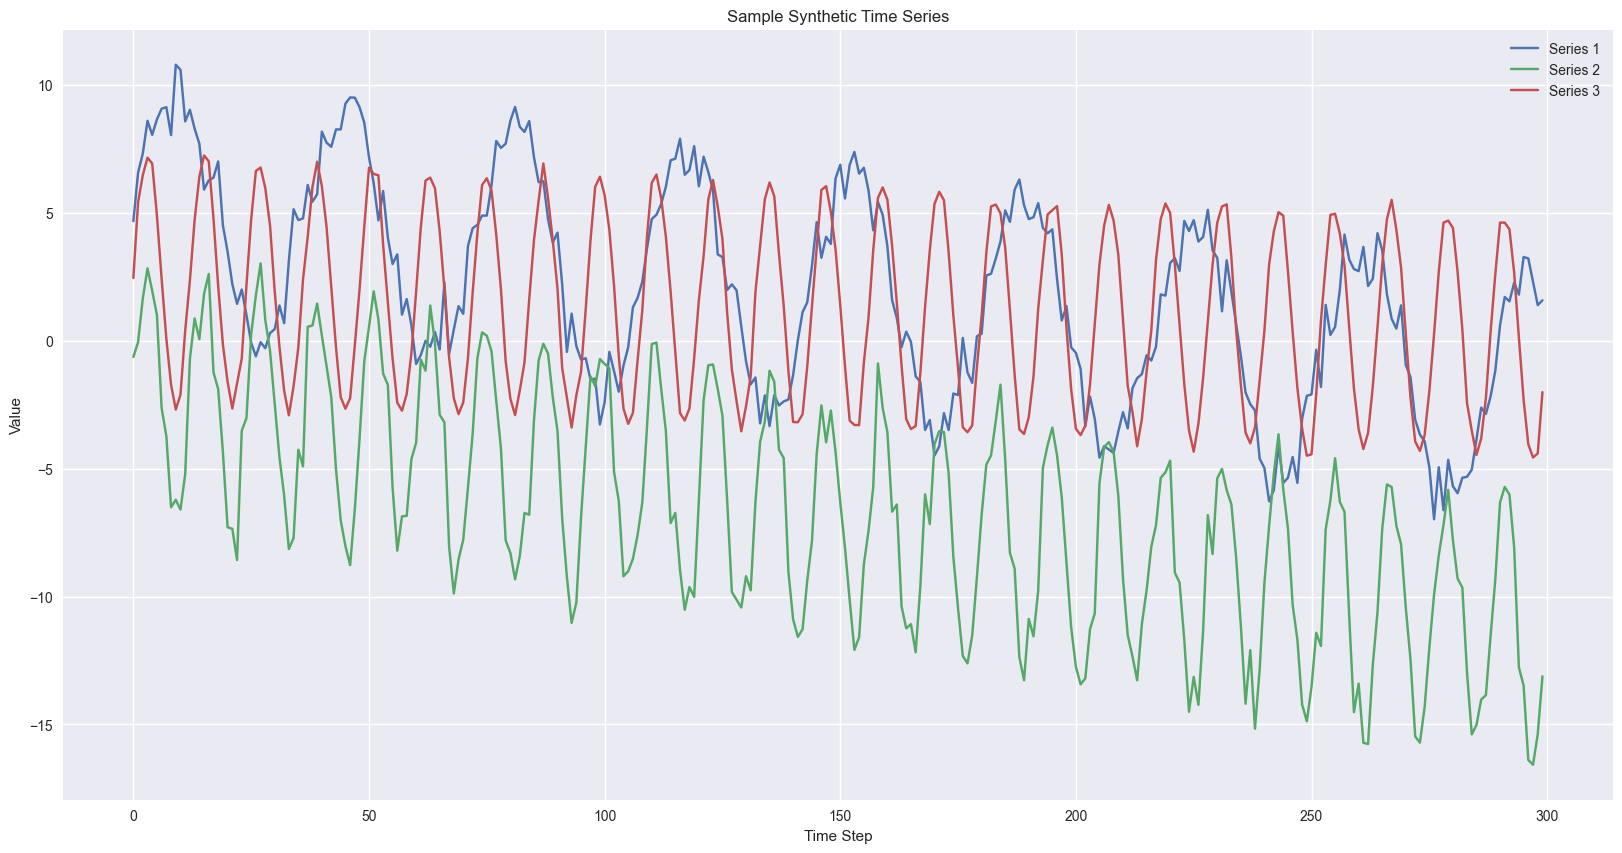

In [19]:

# Generate the data
train_data = generate_time_series(NUM_SERIES_TRAIN, NUM_STEPS)
test_data = generate_time_series(NUM_SERIES_TEST, NUM_STEPS)

print(f"Shape of training data: {train_data.shape}")
print(f"Shape of testing data: {test_data.shape}")

# Visualize a few time series to see the diversity
plt.figure(figsize=(CFG.img_dim1, CFG.img_dim2))
plt.title("Sample Synthetic Time Series")
for i in range(3):
    plt.plot(train_data[i, :], label=f'Series {i+1}')
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

This code snippet generates synthetic time series data and provides a basic visualization to confirm its creation and diversity.

First, it calls the `generate_time_series` function twice: once to create training data (`train_data`) with `NUM_SERIES_TRAIN` time series of length `NUM_STEPS`, and again to generate testing data (`test_data`) with `NUM_SERIES_TEST` time series, also of length `NUM_STEPS`. The values for these constants ( defined in the config section above ) determine the size of the datasets. 

Next, it prints the shapes of both the training and testing data arrays to verify that they have been created correctly. This confirms the number of time series and their lengths.

Finally, it generates a plot showing three randomly selected time series from the training data. The `plt.figure` command creates a new figure for plotting. A title is added to the plot.  A loop iterates through the first three time series in the `train_data` array, plotting each one with a different label. Axis labels and a grid are added for clarity, and the legend displays the labels of each plotted series. The `plt.show()` command displays the generated plot. This visualization allows you to visually inspect the generated data and confirm that it exhibits some degree of diversity in terms of trends, seasonality, and noise levels.

In [20]:
# Instantiate models to check parameter counts
_l1_linear = LinearModel(CONTEXT_LENGTH, FORECAST_HORIZON)
_l1_mlp = MLPModel(CONTEXT_LENGTH, FORECAST_HORIZON)

print(f"L1 LinearModel params: {sum(p.numel() for p in _l1_linear.parameters())}")
print(f"L1 MLPModel params: {sum(p.numel() for p in _l1_mlp.parameters())}")

L1 LinearModel params: 1224
L1 MLPModel params: 26136


This code snippet instantiates two level 1 (L1) models – a `LinearModel` and an `MLPModel` – and then prints the number of trainable parameters in each model. This is useful for understanding the complexity of each model and comparing their sizes.

First, it creates instances of both `LinearModel` and `MLPModel`, passing in the `CONTEXT_LENGTH` and `FORECAST_HORIZON` as arguments to define their input and output dimensions. The underscore prefix (`_`) indicates that these models are created for inspection purposes only and aren't intended to be used directly in training.

Then, it calculates the total number of parameters in each model using a generator expression and the `sum()` function.  The generator expression `(p.numel() for p in _l1_linear.parameters())` iterates through all the parameters (`p`) within the `_l1_linear` model and calls `p.numel()` on each parameter to get its number of elements (i.e., the size of the tensor). The same is done for the `_l1_mlp` model.

Finally, it prints the calculated number of parameters for both models using f-strings, providing a clear indication of their respective complexities. This information can be helpful when choosing appropriate models or tuning hyperparameters.

# Run Forrest run

In [21]:
# --- Instantiate all models for the experiment ---
l1_models_to_train = {
    'SeasonalNaive': SeasonalNaiveModel(seasonality=24),
    'Linear': LinearModel(CONTEXT_LENGTH, FORECAST_HORIZON),
    'MLP': MLPModel(CONTEXT_LENGTH, FORECAST_HORIZON)
}

l2_stackers_to_train = {
    'Median': MedianStacker(),
    'LinearStacker': LinearStacker(len(l1_models_to_train), FORECAST_HORIZON),
    'MLPStacker': MLPStacker(len(l1_models_to_train), FORECAST_HORIZON)
}

l3_aggregator_to_train = GreedyEnsemble(num_steps=100)


This code snippet instantiates all the models that will be used in the multi-layer stacking ensemble experiment. It defines dictionaries containing instances of the level 1 (L1) models, level 2 (L2) stackers, and the level 3 (L3) aggregator.

The `l1_models_to_train` dictionary stores the L1 models that will be trained and used to generate initial predictions. It includes a `SeasonalNaiveModel` with a seasonality of 24, a `LinearModel`, and an `MLPModel`. The `CONTEXT_LENGTH` and `FORECAST_HORIZON` are passed as arguments to define the input and output dimensions of the linear and MLP models.

The `l2_stackers_to_train` dictionary stores the L2 stacker models that will combine the predictions from the L1 models. It includes a `MedianStacker`, a `LinearStacker`, and an `MLPStacker`. The `LinearStacker` and `MLPStacker` are initialized with the number of L1 models (obtained using `len(l1_models_to_train)`) and the `FORECAST_HORIZON`.

Finally, the `l3_aggregator_to_train` variable is assigned an instance of the `GreedyEnsemble` class. The `num_steps` parameter is set to 100, controlling the number of iterations in the greedy ensemble selection process.

These instantiations prepare all the necessary components for training and evaluating the multi-layer stacking ensemble.

In [22]:
# Run the full training pipeline
l1_models_final, l2_stackers_final, l3_aggregator_final = train_multi_layer_stacker(
    l1_models_to_train,
    l2_stackers_to_train,
    l3_aggregator_to_train,
    train_data,
    NUM_FOLDS,
    CONTEXT_LENGTH,
    FORECAST_HORIZON
)

--- Generating L1 Out-of-Fold (OOF) Predictions ---
Fold 1/5: Training L1 models on data up to step 180
Fold 2/5: Training L1 models on data up to step 204
Fold 3/5: Training L1 models on data up to step 228
Fold 4/5: Training L1 models on data up to step 252
Fold 5/5: Training L1 models on data up to step 276
Finished L1 OOF generation.
Shape of L1 OOF predictions (L1-Pred features): (500, 3, 24)
Shape of L1 OOF targets (L1-Pred targets): (500, 24)

--- Training L2 Stackers and Generating L3 Training Data ---
Training L2 Stacker: Median
Training L2 Stacker: LinearStacker
  Epoch 10/50, Loss: 0.7076
  Epoch 20/50, Loss: 0.6504
  Epoch 30/50, Loss: 0.6124
  Epoch 40/50, Loss: 0.5895
  Epoch 50/50, Loss: 0.5700
Training L2 Stacker: MLPStacker
  Epoch 10/50, Loss: 0.5097
  Epoch 20/50, Loss: 0.5074
  Epoch 30/50, Loss: 0.5123
  Epoch 40/50, Loss: 0.5096
  Epoch 50/50, Loss: 0.5055
Shape of L2 OOF predictions (L3 training features): (100, 3, 24)
Shape of L3 training targets: (100, 24)

---

This line of code executes the core training process for the multi-layer stacking ensemble. It calls the `train_multi_layer_stacker` function with all the necessary inputs to train the L1 models, L2 stackers, and L3 aggregator.

The arguments passed to the function are:

*   `l1_models_to_train`: The dictionary of L1 models that will be trained.
*   `l2_stackers_to_train`: The dictionary of L2 stacker models that will be trained.
*   `l3_aggregator_to_train`: The L3 aggregator model that will be trained.
*   `train_data`: The training data used to train all the models.
*   `NUM_FOLDS`: The number of folds for cross-validation during L1 model training.
*   `CONTEXT_LENGTH`: The length of the input context window.
*   `FORECAST_HORIZON`: The number of time steps to forecast into the future.

The function returns three updated dictionaries: `l1_models_final`, `l2_stackers_final`, and `l3_aggregator_final`. These dictionaries contain the fully trained L1 models, L2 stackers, and L3 aggregator, respectively, ready for making predictions on new data. The returned values are assigned to these variables, effectively completing the training phase of the experiment.

In [23]:

# Demonstrate inference on one test sample
sample_context = test_data[0:1, -CONTEXT_LENGTH-FORECAST_HORIZON:-FORECAST_HORIZON]
print(f"\nSample context shape: {sample_context.shape}")
final_prediction = multilayer_inference(sample_context, l1_models_final, l2_stackers_final, l3_aggregator_final)
print(f"Final prediction for one sample: \n{final_prediction[0, :5]}...")


Sample context shape: (1, 50)
--- Performing Multi-layer Inference ---
L1 predictions shape: (1, 3, 24)
L2 predictions shape: (1, 3, 24)
Final forecast shape: (1, 24)
Final prediction for one sample: 
[-14.44378521 -14.70624605 -14.50395821 -14.64604757 -14.61109066]...


This code snippet demonstrates how to use the trained multi-layer stacking ensemble to make a prediction on a single test sample.

First, it extracts a context window from the `test_data` representing the recent history needed for forecasting. It selects the first time series (`0:1`) and takes a slice of data ending at `-FORECAST_HORIZON`, with a length equal to `CONTEXT_LENGTH + FORECAST_HORIZON`. This provides the input sequence for the model. The shape of this sample context is printed for verification.

Next, it calls the `multilayer_inference` function, passing in the `sample_context`, the trained L1 models (`l1_models_final`), the trained L2 stackers (`l2_stackers_final`), and the trained L3 aggregator (`l3_aggregator_final`). This generates a prediction for the forecast horizon.

Finally, it prints the first five values of the final prediction using slicing (`[0, :5]`) to provide a glimpse of the forecasted output. The ellipsis ("...") indicates that only a portion of the full prediction is being displayed.

In [24]:
all_predictions = evaluate_performance()


--- Running Final Evaluation on Test Set ---
--- Generating L1 Out-of-Fold (OOF) Predictions ---
Fold 1/5: Training L1 models on data up to step 180
Fold 2/5: Training L1 models on data up to step 204
Fold 3/5: Training L1 models on data up to step 228
Fold 4/5: Training L1 models on data up to step 252
Fold 5/5: Training L1 models on data up to step 276
Finished L1 OOF generation.
Shape of L1 OOF predictions (L1-Pred features): (500, 3, 24)
Shape of L1 OOF targets (L1-Pred targets): (500, 24)
L1 Model 'SeasonalNaive' OOF MAE: 1.8765
L1 Model 'Linear' OOF MAE: 0.5209
L1 Model 'MLP' OOF MAE: 0.5440
==> Best L1 Model selected: Linear
--- Performing Multi-layer Inference ---
L1 predictions shape: (4540, 3, 24)
L2 predictions shape: (4540, 3, 24)
Final forecast shape: (4540, 24)

--- Final Performance Results (MAE on Test Set) ---
| Method                    | MAE     | Improvement vs Median |
|---------------------------|---------|-----------------------|
| Best L1 (Linear)       | 0.481

This line of code calls the `evaluate_performance` function and stores the returned results in the variable `all_predictions`.

The `evaluate_performance` function performs a comprehensive evaluation of the trained models on the test dataset. It calculates performance metrics (specifically, Mean Absolute Error or MAE) for several methods: the best single L1 model, a median baseline, a single-layer stacker, and the full multi-layer stacking ensemble. 

The `evaluate_performance` function also returns a dictionary containing the predictions from each of these methods, along with the ground truth test targets. This dictionary is assigned to the variable `all_predictions`, allowing for further analysis or visualization of the results.

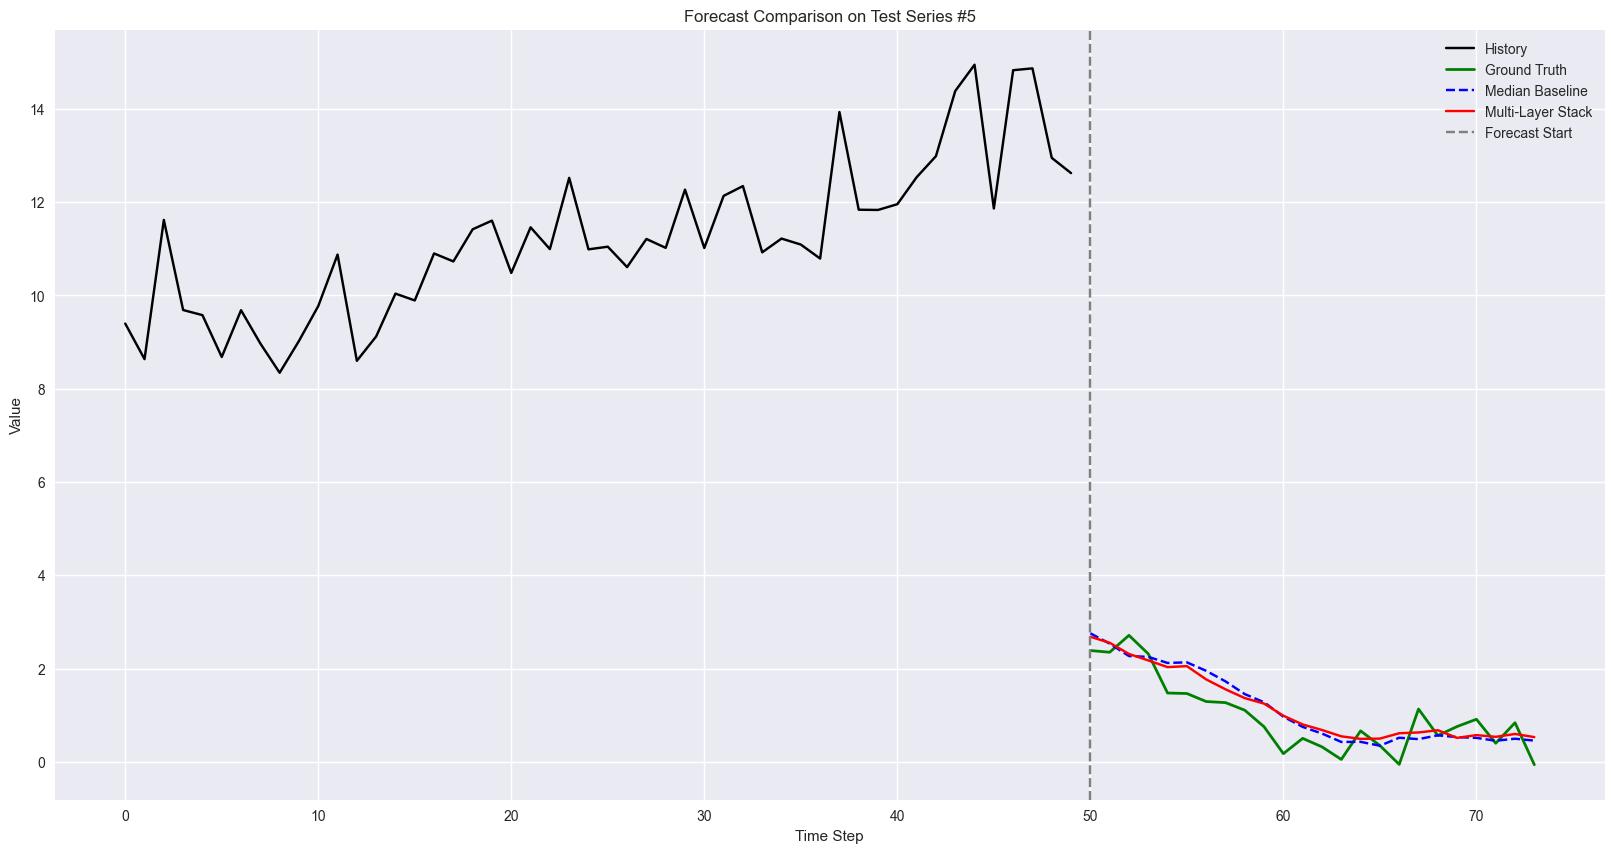

In [25]:
# Plot 1: Forecast Comparison on a Test Series
plot_forecast_comparison(all_predictions, series_idx=5)

This line of code generates a visual comparison of the forecasts made by different models against the actual values for a specific time series from the test set.

It calls the `plot_forecast_comparison` function, passing in the dictionary of predictions (`all_predictions`) returned by the `evaluate_performance` function and specifying the index of the time series to plot (`series_idx=5`). This will create a plot showing:

*   The historical context (recent past) used for forecasting.
*   The ground truth values (actual future values).
*   The forecasts generated by the median baseline, and the multi-layer stacker. 

A vertical line indicates where the forecast begins, allowing for a clear visual assessment of how well each model predicts the future values compared to the actual observations.

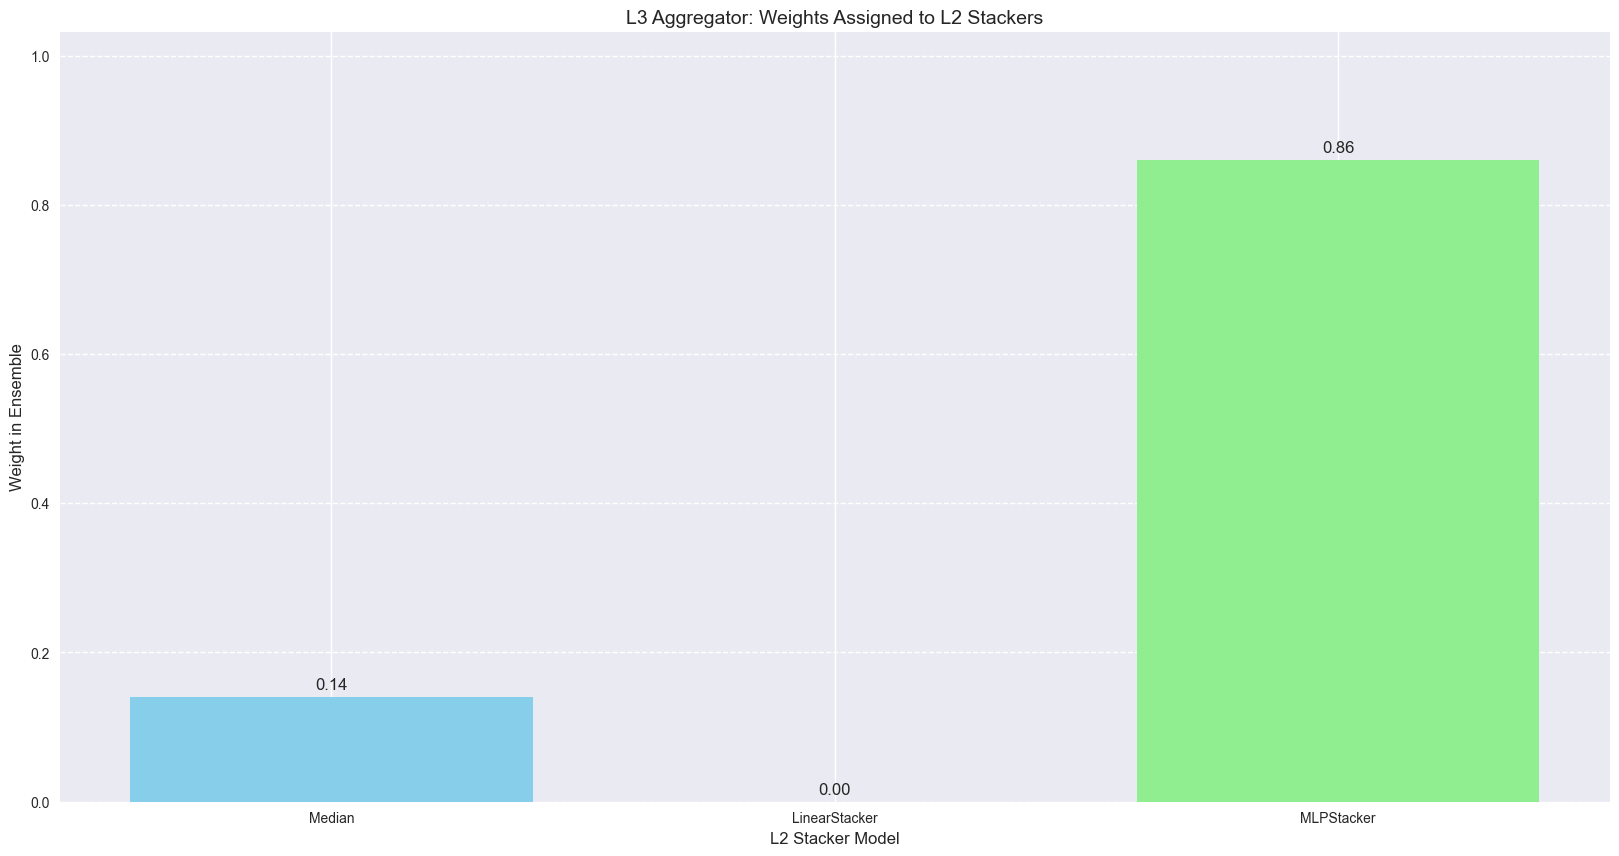

In [26]:

# Plot 2: L3 Aggregator Weights
plt.figure(figsize=(CFG.img_dim1, CFG.img_dim2))
plt.title("L3 Aggregator: Weights Assigned to L2 Stackers", fontsize=14)
l2_names = list(l2_stackers_final.keys())
weights = l3_aggregator_final.weights
plt.bar(l2_names, weights, color=['skyblue', 'salmon', 'lightgreen'])
plt.ylabel("Weight in Ensemble", fontsize=12)
plt.xlabel("L2 Stacker Model", fontsize=12)
for i, w in enumerate(weights):
    plt.text(i, w + 0.01, f'{w:.2f}', ha='center', fontsize=12)
plt.ylim(0, max(weights) * 1.2)
plt.grid(axis='y', linestyle='--')
plt.show()

This code snippet generates a bar plot visualizing the weights assigned to each level 2 (L2) stacker by the level 3 (L3) aggregator. This provides insight into which L2 models the aggregator considers most important for making accurate predictions.

First, it creates a new figure with dimensions specified by `CFG.img_dim1` and `CFG.img_dim2` (presumably defined elsewhere in the code). A title is added to the plot indicating that it displays the weights assigned by the L3 aggregator.

It retrieves the names of the L2 stacker models from the keys of the `l2_stackers_final` dictionary and stores them in the `l2_names` list. It also extracts the learned weights from the `l3_aggregator_final.weights` attribute.

A bar plot is created using `plt.bar`, with the L2 model names on the x-axis and their corresponding weights on the y-axis. The bars are colored skyblue, salmon, and lightgreen. Axis labels are added for clarity.

The code then iterates through the weights and adds text annotations above each bar displaying the weight value formatted to two decimal places. This makes it easy to read the exact weight assigned to each L2 model.

The y-axis limits are set using `plt.ylim` to ensure that all bars are fully visible, with a small margin at the top. A horizontal grid is added for better readability. Finally, `plt.show()` displays the generated plot.

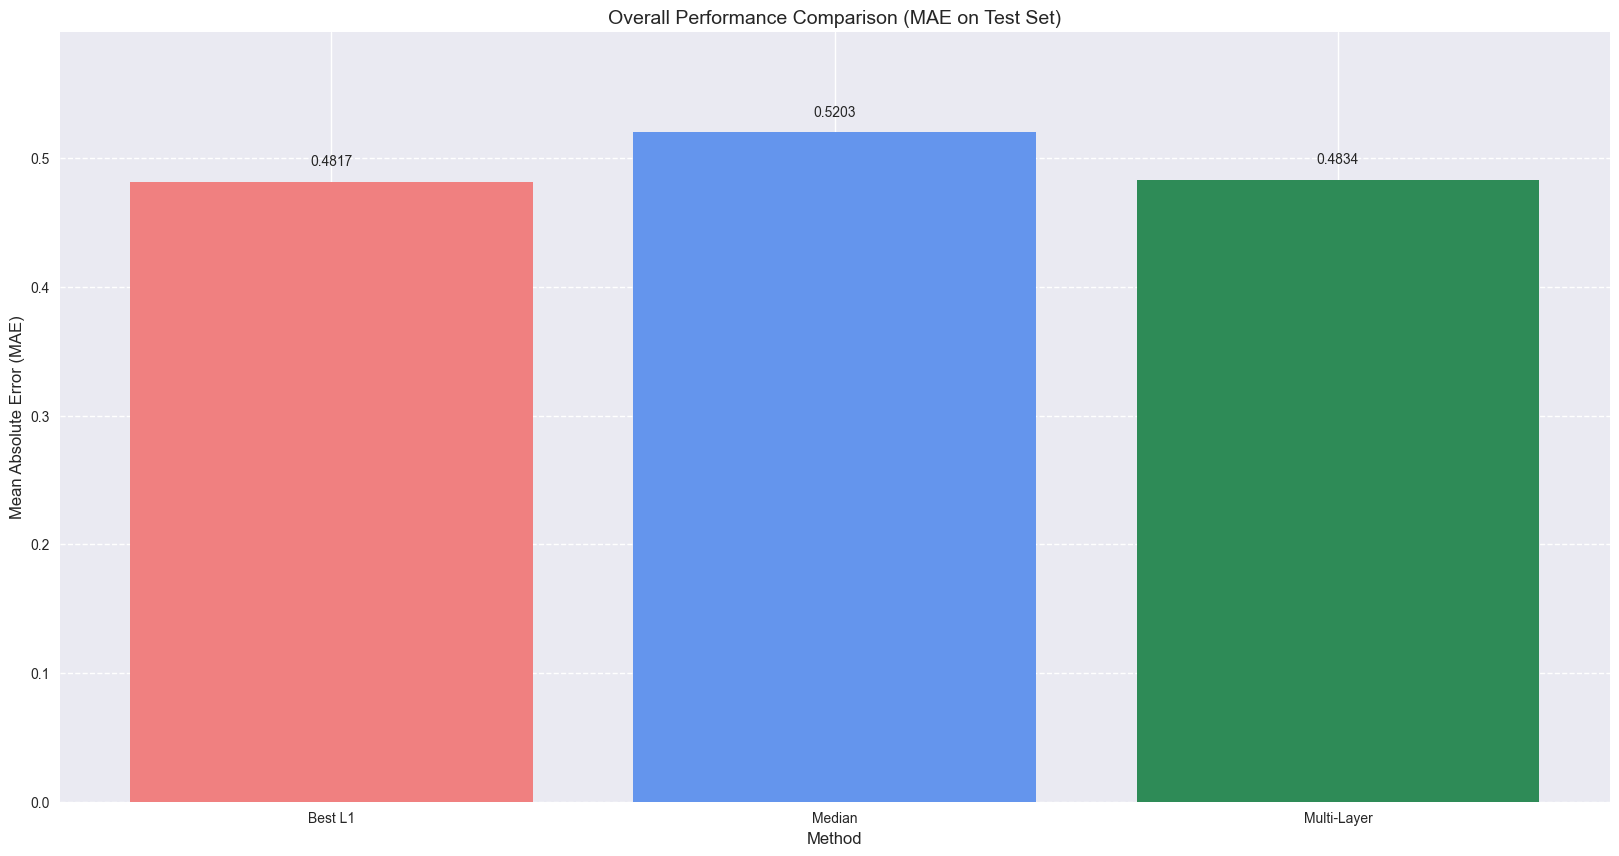

In [27]:
# Plot 3: Overall Performance Comparison
results_mae = {
    f"Best L1": np.mean(np.abs(all_predictions["Best L1"] - all_predictions["Ground Truth"])),
    "Median": np.mean(np.abs(all_predictions["Median"] - all_predictions["Ground Truth"])),
    "Multi-Layer": np.mean(np.abs(all_predictions["Multi-Layer"] - all_predictions["Ground Truth"]))
}
plt.figure(figsize=(CFG.img_dim1, CFG.img_dim2))
plt.title("Overall Performance Comparison (MAE on Test Set)", fontsize=14)
methods = list(results_mae.keys())
mae_values = list(results_mae.values())
bars = plt.bar(methods, mae_values, color=['lightcoral', 'cornflowerblue', 'seagreen'])
plt.ylabel("Mean Absolute Error (MAE)", fontsize=12)
plt.xlabel("Method", fontsize=12)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.4f}', ha='center', va='bottom')
plt.ylim(0, max(mae_values) * 1.15)
plt.grid(axis='y', linestyle='--')
plt.show()

This code snippet generates a bar plot comparing the overall performance of different forecasting methods based on their Mean Absolute Error (MAE) on the test set.

First, it calculates the MAE for each method using the predictions and ground truth values stored in the `all_predictions` dictionary. The results are stored in the `results_mae` dictionary, with keys representing the method names ("Best L1", "Median", "Multi-Layer") and values representing their corresponding MAEs.

Next, it creates a new figure with dimensions specified by `CFG.img_dim1` and `CFG.img_dim2`. A title is added to the plot indicating that it displays an overall performance comparison based on MAE.

It extracts the method names from the keys of the `results_mae` dictionary and stores them in the `methods` list, and similarly extracts the MAE values into the `mae_values` list.

A bar plot is created using `plt.bar`, with the method names on the x-axis and their corresponding MAE values on the y-axis. The bars are colored lightcoral, cornflowerblue, and seagreen. Axis labels are added for clarity.

The code then iterates through each bar in the plot and adds a text annotation above it displaying the exact MAE value formatted to four decimal places. This makes it easy to read the performance of each method directly from the plot.

The y-axis limits are set using `plt.ylim` to ensure that all bars are fully visible, with a small margin at the top. A horizontal grid is added for better readability. Finally, `plt.show()` displays the generated plot.

--- Generating L1 Out-of-Fold (OOF) Predictions ---
Fold 1/5: Training L1 models on data up to step 180
Fold 2/5: Training L1 models on data up to step 204
Fold 3/5: Training L1 models on data up to step 228
Fold 4/5: Training L1 models on data up to step 252
Fold 5/5: Training L1 models on data up to step 276
Finished L1 OOF generation.
Shape of L1 OOF predictions (L1-Pred features): (500, 3, 24)
Shape of L1 OOF targets (L1-Pred targets): (500, 24)


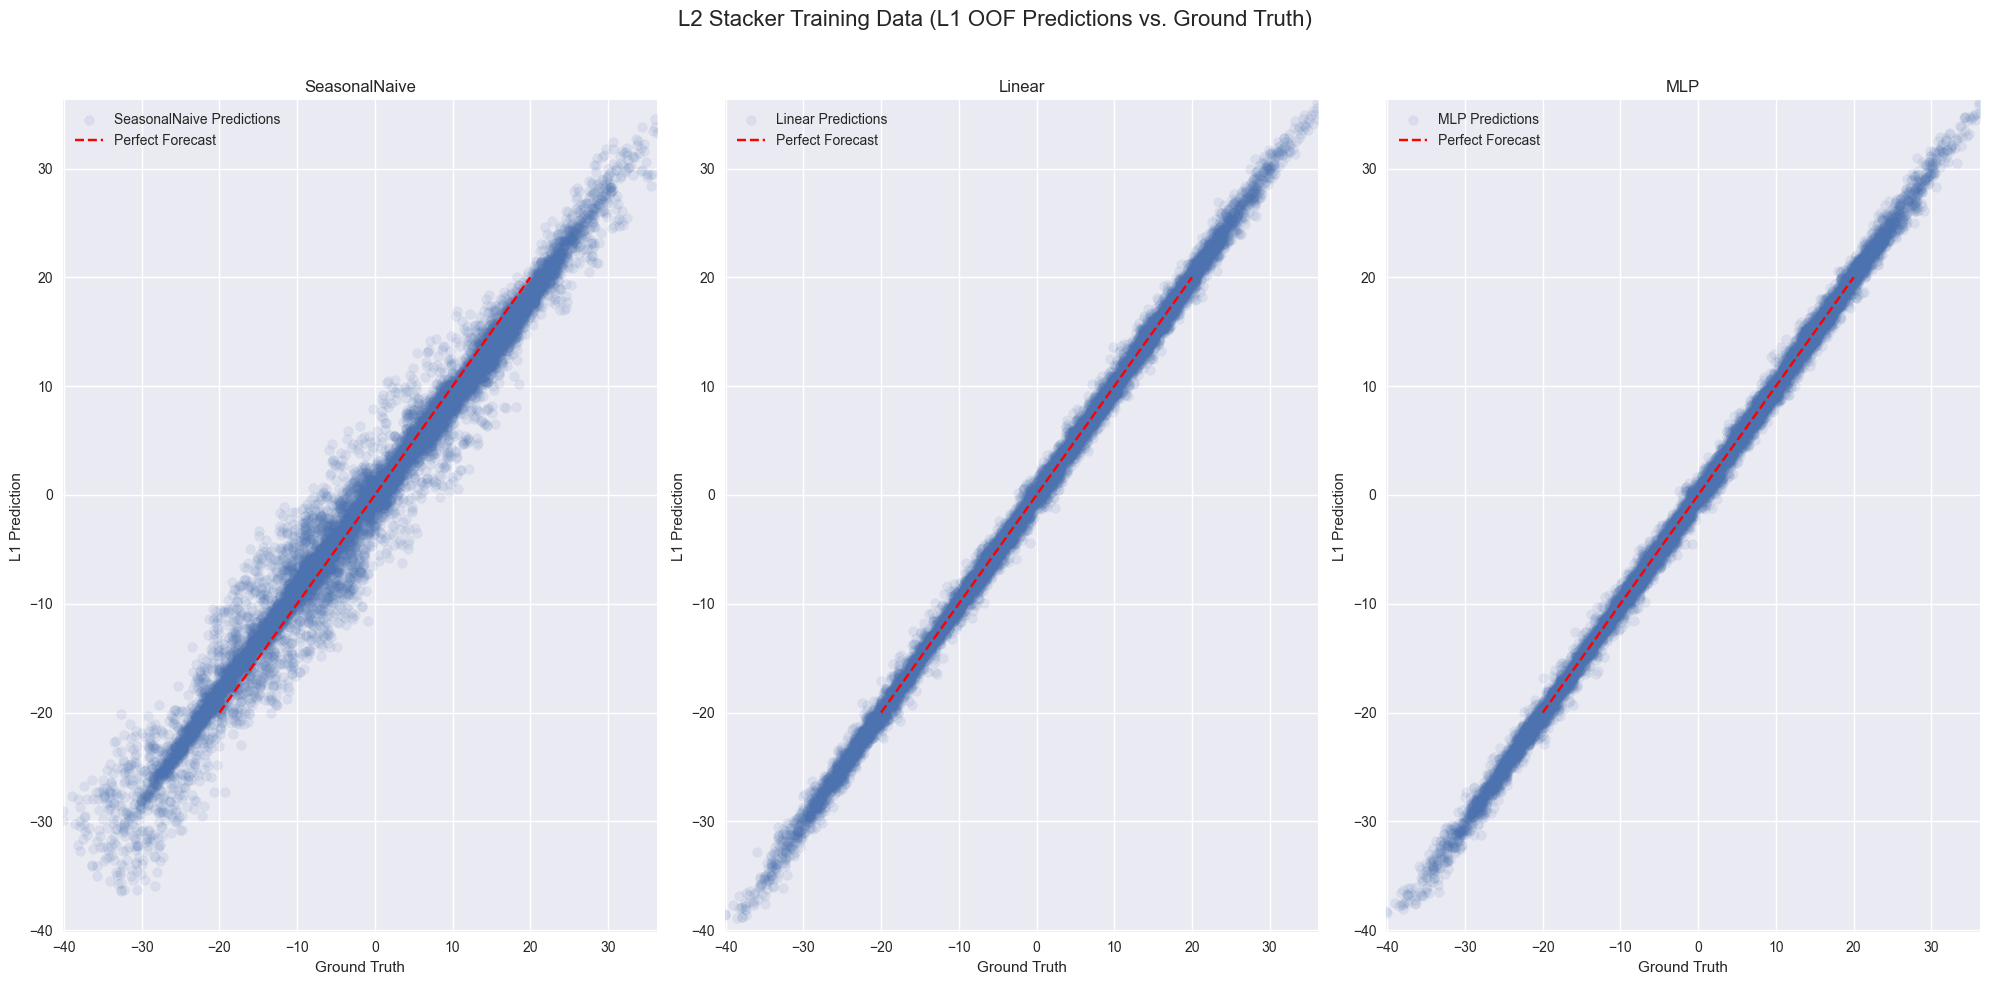

In [28]:

# Plot 4: L2 Stacker Training Data Visualization
l1_oof_preds, l1_oof_targets = generate_l1_oof_predictions(l1_models_to_train, train_data, NUM_FOLDS, CONTEXT_LENGTH, FORECAST_HORIZON)
# Flatten for plotting: we'll plot each time step as a point
flat_targets = l1_oof_targets.flatten()

plt.figure(figsize=(CFG.img_dim1, CFG.img_dim2))
plt.suptitle("L2 Stacker Training Data (L1 OOF Predictions vs. Ground Truth)", fontsize=16)
for i, name in enumerate(l1_models_to_train.keys()):
    ax = plt.subplot(1, 3, i + 1)
    flat_preds = l1_oof_preds[:, i, :].flatten()
    ax.scatter(flat_targets, flat_preds, alpha=0.1, label=f'{name} Predictions')
    ax.plot([-20, 20], [-20, 20], 'r--', label='Perfect Forecast') # Identity line
    ax.set_title(name)
    ax.set_xlabel("Ground Truth")
    ax.set_ylabel("L1 Prediction")
    ax.grid(True)
    ax.legend()
    ax.set_xlim(min(flat_targets), max(flat_targets))
    ax.set_ylim(min(flat_targets), max(flat_targets))

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

This code snippet generates a series of scatter plots to visualize the relationship between the L1 model predictions and the ground truth targets used for training the L2 stackers. This helps assess how well each L1 model captures the underlying patterns in the data.

First, it calls `generate_l1_oof_predictions` to obtain the out-of-fold (OOF) predictions from the L1 models and their corresponding ground truth targets. The OOF predictions serve as the training data for the L2 stackers.

The code then flattens the `l1_oof_targets` array into a 1D array called `flat_targets`. This is done to simplify plotting, treating each time step as an individual data point.

A figure is created with dimensions specified by `CFG.img_dim1` and `CFG.img_dim2`, and a supertitle is added to provide context for the plots. Three subplots are created using `plt.subplot(1, 3, i + 1)`, arranged in one row and three columns.

The code then iterates through each L1 model in the `l1_models_to_train` dictionary. For each model:

*   It flattens the corresponding OOF predictions (`l1_oof_preds[:, i, :]`) into a 1D array called `flat_preds`.
*   A scatter plot is created using `ax.scatter`, plotting the ground truth values (`flat_targets`) on the x-axis and the L1 model’s predictions (`flat_preds`) on the y-axis. The points are semi-transparent (alpha=0.1) to reveal density patterns.
*   A red dashed line representing a perfect forecast (where predictions equal ground truth) is plotted using `ax.plot([-20, 20], [-20, 20], 'r--')`.
*   The subplot is titled with the name of the L1 model. Axis labels and a grid are added for clarity. A legend is included to identify the scatter plot.
*   The x and y axis limits are set to be equal based on the range of `flat_targets` to ensure consistent scaling across all subplots.

Finally, `plt.tight_layout(rect=[0, 0, 1, 0.96])` adjusts the subplot parameters to provide reasonable spacing between plots and prevent overlapping with the supertitle. The plot is then displayed using `plt.show()`. These scatter plots allow you to visually assess how well each L1 model’s predictions align with the actual values, identifying potential biases or limitations in their forecasting capabilities.